# **Tutorial for DICGrid model component**

DIC Grid serves for reading the data available as a sequence of files with displacement measurements stored in a directory, accompanied with the measured load deflection curve. It refers to the `BeamDesign` object defining the design of the reinforced beam. By combining the information from the optical measurement with statical scheme, geometry and reinforcement layout, this model component serves 
further analysis by providing the correct **load-space-time** databasis.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import collections
collections.Iterable = collections.abc.Iterable
from scipy.spatial import Delaunay

Let us construct a grid example and render the interactive interface showing the measured displacmeent at the maximum load $t = 1$ and with displacement amplified by a factor $U_\mathrm{factor} = 100$. 

In [2]:
from bmcs_shear.api import DICGridTri
dic_grid = DICGridTri(U_factor=100, dir_name='B10_TV1', t=1, padding=40, d_x=3, d_y=3, n_T_max=40, T_stepping='delta_T')
#dic_grid = DICGridTri(U_factor=100, dir_name='BASE', t=1, padding=40, d_x=3, d_y=3, n_T=2, time_m_skip=1)
dic_grid.read_beam_design()

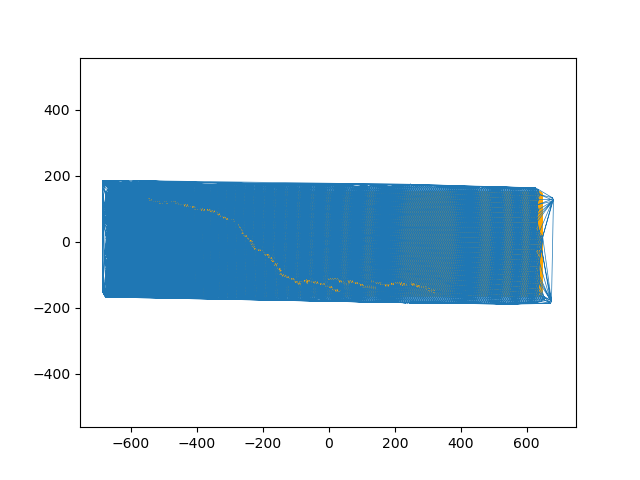

In [3]:
%matplotlib widget
fig, ax = plt.subplots(1,1)
dic_grid.plot_grid_on_triangulation(ax)

In [4]:
dic_grid.interact()

Note that the orange markers denote the states with available DIC measurements performed during the history of loading.

In [5]:
dic_grid.time_F_T

(array([   0.   ,  146.405,  312.189,  923.529,  962.045, 1572.916,
        1611.372, 2182.163, 2677.876, 2753.843, 3328.058, 3366.473,
        4125.801, 4202.918, 4761.1  , 4856.1  , 5556.1  , 5626.1  ,
        6194.9  ]),
 array([-1.291000e-01,  5.315200e+00,  2.121870e+01,  4.242330e+01,
         4.772480e+01,  6.892860e+01,  7.423160e+01,  9.543750e+01,
         1.113431e+02,  1.219463e+02,  1.431501e+02,  1.484514e+02,
         1.643548e+02,  1.749555e+02,  1.890315e+02,  2.000708e+02,
         2.108882e+02,  2.151870e+02,  2.153849e+02]))

## Read data format

### Input directory structure

The `DICGrid` objects reads the data from a directory named as `dir_name`

In [6]:
dic_grid.dir_name

'B10_TV1'

The property trait `data_dir` assembles the path to the data directory using path starting in the home directory, i.e. 

```join(dic_grid.home_dir, 'simdb', 'data', 'shear_zone', dic_grid.dir_name)```

For the current example, we obtain

In [7]:
dic_grid.data_dir

'C:\\Users\\fahad\\simdb\\data\\shear_zone\\B10_TV1'

To get the directory with the DIC data, issue 

In [8]:
dic_grid.dic_data_dir

'C:\\Users\\fahad\\simdb\\data\\shear_zone\\B10_TV1\\dic_point_data'

### Load deflection response

To obtain the directory with the load deflection curve, use

In [9]:
dic_grid.time_F_w_data_dir

'C:\\Users\\fahad\\simdb\\data\\shear_zone\\B10_TV1\\load_deflection'

### Beam parameters
File specifying the beam parameters is assessed using the property traits `beam_param_fie` and is named `beam_params.txt` by default

In [10]:
dic_grid.beam_param_file

'C:\\Users\\fahad\\simdb\\data\\shear_zone\\B10_TV1\\beam_params.txt'

This file specifies the parameters 
 - length $L$
 - width $B$
 - depth $H$
 - number of reinforcement bars $n_\mathrm{s}$
 - vertical position of the bars $y_\mathrm{s}$
 - diameter of the reinforcement $d_\mathrm{s}$

In [11]:
dic_grid.beam_param_types

{'L_right': float,
 'L_left': float,
 'B': float,
 'H': float,
 'n_s': float,
 'y_s': float,
 'd_s': float}

Currently, to setup the beam parmaters correctly, a call to `read_beam_design` must be issued using

In [12]:
dic_grid.read_beam_design()

**Note** This need should be avoided later by capturing the dependency with respect to the `data_dir` attribute. Currently, the notification mechanism does not allow this because of are further dependency links.

The beam design object is available in the attribute `sz_bd`. The type of the `RCBeamDesign` is general and specifies also the material models associated with individual material components.

The parameters relevant for correct configuration of the `dic_grid` within the beam design are the length and offset with respect the beam bounaries 

In [13]:
dic_grid.dic_data_dir

'C:\\Users\\fahad\\simdb\\data\\shear_zone\\B10_TV1\\dic_point_data'

In [14]:
dic_grid.L_x, dic_grid.L_y

(1367.3943, 374.4656)

### Grid parameters

File specifying the grid data parameters is accessed using the property trait `grid_param_file` and is named
`grid_params.txt` by default.

In [15]:
dic_grid.dic_param_file

'C:\\Users\\fahad\\simdb\\data\\shear_zone\\B10_TV1\\dic_point_data\\dic_params.txt'

This file contains the name-value pairs of the attributes defined by the `grid_param_types` dictionary

In [16]:
dic_grid.dic_param_types

{'x_offset': float,
 'y_offset': float,
 'pad_t': float,
 'pad_b': float,
 'pad_l': float,
 'pad_r': float}

Thus, the `grid_params` of the current test `B7_TV1` read

In [17]:
dic_grid.dic_params

{'x_offset': 1.0,
 'y_offset': 10.0,
 'pad_t': 40.0,
 'pad_b': 35.0,
 'pad_l': 35.0,
 'pad_r': 45.0}

The DIC data files corresponding to each measured step are assembled in the string list `files` 

These parameters are available as properties and can be accessed via

In [26]:
dic_grid.n_I, dic_grid.n_J, dic_grid.d_x, dic_grid.d_y, dic_grid.x_offset, dic_grid.y_offset

(453, 124, 3.0, 3.0, 1.0, 10.0)

Note that the naming of properties follows the mathematical indexing convention with $I$, $J$ representing the horizontal and vertical node indexes, respectively. Correspondingly, $n_I$ and $n_J$ denotes the number of horizontal and vertical nodes, respectively. 

To position the DIC frame into the beam, the beam parameters and grid parameters are combined to obtain the coordinates of the 
bottom left and top right corners within the beam in the order $X_\mathrm{frame} = (x_\min, y_\min, x_\max, y_\max)$

In [27]:
dic_grid.X_frame

(1.0, 10.0, 1282.3921, 309.4656)

In [28]:
dic_grid.dic

AttributeError: 'DICGridTri' object has no attribute 'dic'

Note that the `CSV` files are named according to the scheme specifying their load levels

## Time data

The load `F` corresponding to each history index `T` is provided in the `F_dic_T` property.

In [29]:
dic_grid.F_dic_T

AttributeError: 'DICGridTri' object has no attribute 'F_dic_T'

The index corresponding to the maximum load `F` is accessed via

The final index of snapshots is also available as `n_T`

In [30]:
dic_grid.n_T

30

An instance of `dic_grid` keeps track of the current time $t \in (0, 1)$ with 0 
and 1 representing the states with zero and maximum force, respectively. Thus, by setting

In [31]:
dic_grid.t = 0.5

The grid will return displacement and position values corresponding to the half of the maximum load. When setting the value of $t$, the value of `T1` denoting the history index will be adapted automateically, i.e.

In [32]:
dic_grid.T0, dic_grid.n_T

(0, 30)

The whole load and deflection values for each history index $T$ are available in the table `Fw_T`, representing the raw format of the measured data. The 

In [33]:
dic_grid.Fw_T.shape

AttributeError: 'DICGridTri' object has no attribute 'Fw_T'

To access the deflections and forces, we need to issue

In [34]:
w = dic_grid.Fw_T[::50,2]
F = -dic_grid.Fw_T[::50,1]

AttributeError: 'DICGridTri' object has no attribute 'Fw_T'

**TODO**: provide properties

In [35]:
dic_grid.t = 1
dic_grid.F_T_t

215.0536

## Grid data

The initial positions of the grid markers denoted as $X_{0IJa}$ is obtained from the `grid_params`. The initial position of the 
bottom left corner must match the values of the offset specified above in the $X_\mathrm{frame}$. Let us verify that this feature is provided by printing the values of `X_0IJa[0,0,:]` and `X_0IJa[-1,-1,:]`.

In [36]:
dic_grid.X_frame, dic_grid.X_IJa[0, 0, :], dic_grid.X_IJa[-1, -1, :]

((1.0, 10.0, 1282.3921, 309.4656),
 array([ 1., 10.]),
 array([1282.3921,  309.4656]))

All files are read into the memory at once. This might be improvied in the future using the zipped binary `numpy` file management to save memory during processing.

The displacements of the grid nodes are stored in a four-dimensional array 
$U_{TIJa}$ with the indexes denoting the history index $T$, horizontal 
node index $I$, vertical index $J$, and the dimension index $a \in (0,1) = (x,y)$.
Thus, the displacement at the fifteenth step of the left bottom corner node
in both directions can be obtained as

In [37]:
dic_grid.U_TIJa[-1, 40, 0, :]

array([-0.82632728, -8.45431066])

The displacement corresponding to the current value of $t$ represented by the index T_t

In [38]:
dic_grid.t, dic_grid.T_t

(1.0, 29)

is available as property $U_{IJa}$

In [39]:
dic_grid.U_IJa[40, 0, :]

array([-0.82632728, -8.45431066])

If a new time is set

In [40]:
dic_grid.t = 0.6

A new value of displacement is obtained as

In [41]:
dic_grid.U_IJa[40, 0, :]

array([-0.71933625, -7.42362638])

# Plotting functions

In [ ]:
%matplotlib widget
_, ax = plt.subplots(1,1)
dic_grid.t = 0.2
dic_grid.plot_load_deflection(ax)

**Remark**: Correct the scaling - t should be between the min max values of the load

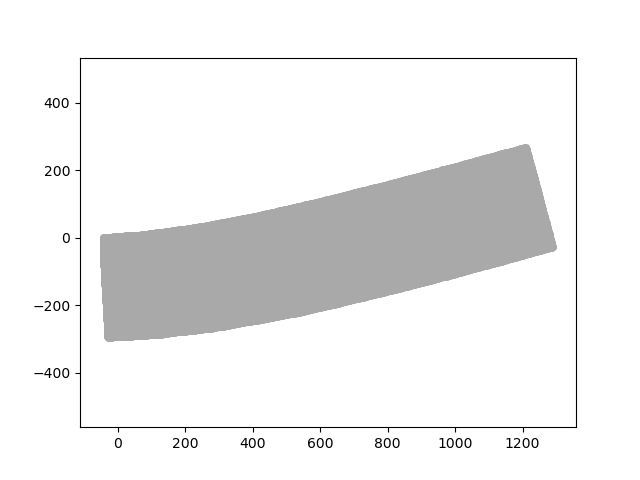

In [43]:
_, ax = plt.subplots(1,1)
dic_grid.plot_grid(ax)

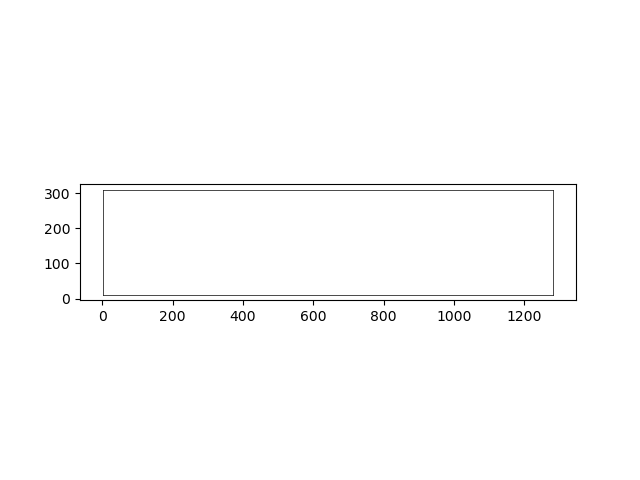

In [44]:
_, ax = plt.subplots(1,1)
dic_grid.plot_bounding_box(ax)
dic_grid.plot_box_annotate(ax)
ax.set_aspect('equal')

# Use case - loop over time steps

In [45]:
import numpy as np
dic_grid.t_dic_T

array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])

In [46]:
dic_grid.t_dic_T[::-1]

array([1.        , 0.96551724, 0.93103448, 0.89655172, 0.86206897,
       0.82758621, 0.79310345, 0.75862069, 0.72413793, 0.68965517,
       0.65517241, 0.62068966, 0.5862069 , 0.55172414, 0.51724138,
       0.48275862, 0.44827586, 0.4137931 , 0.37931034, 0.34482759,
       0.31034483, 0.27586207, 0.24137931, 0.20689655, 0.17241379,
       0.13793103, 0.10344828, 0.06896552, 0.03448276, 0.        ])

In [47]:
T_dic_t = []
for t_dic in dic_grid.t_dic_T:
    dic_grid.t = t_dic
    T_dic_t.append(dic_grid.T_t)
T_dic_t = np.array(T_dic_t)

In [48]:
dic_grid.U_TIJa[T_dic_t,0,-1,1] - dic_grid.U_TIJa[:,0,-1,1] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Interpolation along the time domain is possible using the time index $T$, true time $t$, deflection $w$ or the force $F$.
Time index $T$ refers to the spatial snapshots of dic. 

The load deflection curve is provided in the form $F(t), w(t)$, where $t \in \mathcal{T}$ is the true time. 
The snapshots with DIC are obtained at times $t_\mathrm{dic} \in \mathcal{T}_\mathrm{dic} \subset \mathcal{T}$.

In [49]:
import numpy as np
t, F, w = dic_grid.Fw_T[:,(0,1,2)].T
argmax_F = np.argmax(-F)
-F[:argmax_F]

AttributeError: 'DICGridTri' object has no attribute 'Fw_T'

In [ ]:
t, F, w = [ timeline[:argmax_F] for timeline in [t, -F, w] ] 

In [ ]:
F

In [ ]:
dic_grid.F_dic_T

In [ ]:
dic_grid.U_TIJa[:,0,-1,0].shape, dic_grid.F_dic_T.shape

In [ ]:
idx = 0
idx_list = []
for F_dic in dic_grid.F_dic_T:
    idx += np.argmax(-F[idx:] >= F_dic)
    idx_list.append(idx)
idx_ = np.array(idx_list)

In [ ]:
-F[idx_]

In [ ]:
t = 0.96
self = dic_grid
F = -self.Fw_T[::50,1]
F_max = np.max(F)
F_t = t * F_max
F_dic_T = self.F_dic_T
dic_T = np.arange(len(F_dic_T))
T_t = np.interp(F_t, F_dic_T, dic_T)
int(T_t)

In [ ]:
dic_T